# ANÁLISE EXPLORATÓRIA - JOGOS OLÍMPICOS (1896 - 2016)
____

## 1. Introdução
Construir uma introdução com base histórica

## Importações
Aqui importamos as bibliotecas e definimos os caminhos de trabalho

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import os
import warnings
import requests
import branca
import folium
import json
import matplotlib.lines as lines
import matplotlib.colors as mcolors

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from folium import plugins
from folium.plugins import Search
from folium.plugins import HeatMap
from IPython.display import IFrame
from scipy.interpolate import splrep, splev

dir_atual = os.path.dirname(os.path.abspath('__file__'))
root_dir = os.path.abspath(os.path.join(dir_atual, '..'))
input_path = os.path.join(dir_atual, 'input')
formas_paises_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'

warnings.filterwarnings('ignore')

sns.set()

%matplotlib inline

## Auxiliares

In [4]:
# Função para formatar os valores
def formata_valor(valor):
    if valor < 1_000:
        return f"{valor}"
    elif valor < 1_000_000:
        return f"{valor / 1_000:.0f} K"
    else:
        return f"{valor / 1_000_000:.1f} M"

In [5]:
# Cores especiais
cor_fundo_padrao = '#F4F3F5'
cinzas = ['#8A8A8A', '#5B5B5B', '#424242']
dourados = ["#fdf3da", "#fae3a2", "#f7d46a", "#F0C05A", "#D7A713"]
cores_verao = ['#FED0BD', '#FF6347']
cores_inverno = ['#A7C6DF','#4682B4']

## Carregar Arquivos
A principio, iremos carregar três arquivos: o arquivo de eventos, arquivo de regiões e por último o de coordenadas

In [6]:

dados = pd.read_csv(os.path.join(input_path, 'athlete_events.csv'))
regioes = pd.read_csv(os.path.join(input_path, 'noc_regions.csv'))

output_path = os.path.join(input_path, 'global_polygons.geojson')
response = requests.get(formas_paises_url)
if response.status_code == 200:
    with open(output_path, 'wb') as file:
        file.write(response.content)
else:
    raise 'Erro ao fazer o download do arquivo'

global_poligonos = gpd.read_file(output_path)
global_poligonos.to_file('global_polygons.geojson', driver='GeoJSON')

In [7]:
mesclado = pd.merge(dados, regioes, on='NOC', how='left')
mesclado.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


## Visão Geral
____

### Distribuição de medalhas por competição

In [8]:
# Filtrando as competições por inverno e verão
comp_verao = mesclado[mesclado['Season']=='Summer']   
comp_inverno = mesclado[mesclado['Season']=='Winter']

# Quantidade de competições
num_comp_verao = comp_verao['Year'].nunique()           
num_comp_inverno = comp_inverno['Year'].nunique() 

# Quantidade de medalhas
num_medalhas_verao = comp_verao[comp_verao['Medal'] != 'NA']['Medal'].value_counts().sum()
num_medalhas_inverno = comp_inverno[comp_inverno['Medal'] != 'NA']['Medal'].value_counts().sum()

# Média de medalhas por competição
media_medalha_comp_verao = (num_medalhas_verao)/(num_comp_verao)
media_medalha_comp_inverno = (num_medalhas_inverno)/(num_comp_inverno)

texto_explicativo= f"""
Nos últimos 120 anos 
de comptição 
tivemos {num_comp_verao} competições
de verão e {num_comp_inverno} 
competições de inverno.\n
Foram distribuidas 
{num_medalhas_verao + num_medalhas_inverno} medalhas,
sendo {num_medalhas_verao} nas competições
de verão e {num_medalhas_inverno} 
nas competições de inverno.

Na média,
são distribuidas {media_medalha_comp_verao:.0f} 
medalhas por competição 
no verão e {media_medalha_comp_inverno:.0f} medalhas 
por competição no inverno"""



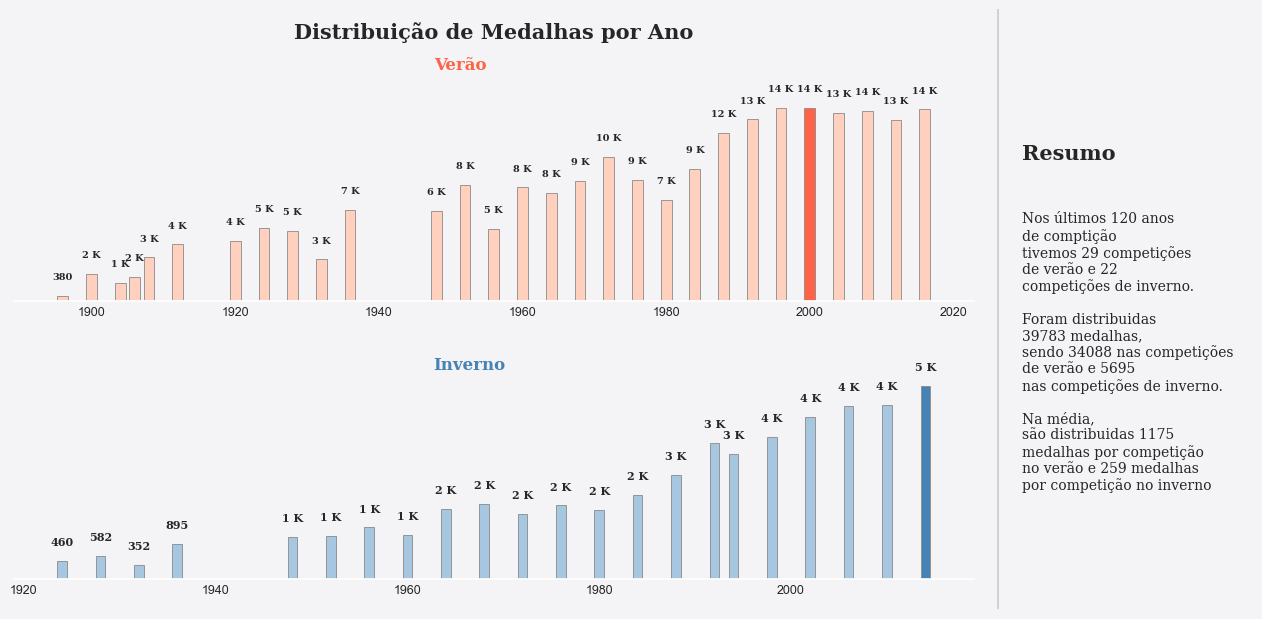

In [194]:
medalhas_ano_verao = comp_verao.groupby(['Year'])['Year'].value_counts().reset_index()
medalhas_ano_verao.set_index('Year', inplace=True)

medalhas_ano_inverno = comp_inverno.groupby(['Year'])['Year'].value_counts().reset_index()
medalhas_ano_inverno.set_index('Year', inplace=True)

medalhas_ano_verao = medalhas_ano_verao.sort_index()
medalhas_ano_inverno = medalhas_ano_inverno.sort_index()

max_verao = medalhas_ano_verao['count'].max()
max_inverno = medalhas_ano_inverno['count'].max()

# Preparar os mapas de cores
color_map_verao = [cores_verao[0] if count != max_verao else cores_verao[1] for count in medalhas_ano_verao['count']]
color_map_inverno = [cores_inverno[0] if count != max_inverno else cores_inverno[1] for count in medalhas_ano_inverno['count']]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 6), facecolor=cor_fundo_padrao)

# As bordas de ambos os gráficos são removidas
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# Plotando o primeiro grafico
ax.bar(x=medalhas_ano_verao.index, height=medalhas_ano_verao['count'],width=1.5, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_verao
       )

# Adicionando os ródulos de dados
for i in medalhas_ano_verao.index:
    ax.annotate(f"{formata_valor(medalhas_ano_verao.at[i, 'count'])}", 
                xy=(i, medalhas_ano_verao.at[i, 'count'] + max_verao*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=7)

ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_verao * 1.2)
ax.set_facecolor(cor_fundo_padrao)

# Plotando o segundo grafico
ax2.bar(x=medalhas_ano_inverno.index, height=medalhas_ano_inverno['count'],width=1, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_inverno
       )

# Adicionando rótulo de dados
for i in medalhas_ano_inverno.index:
    ax2.annotate(f"{formata_valor(medalhas_ano_inverno.at[i, 'count'])}", 
                xy=(i, medalhas_ano_inverno.at[i, 'count'] +  max_inverno*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8)

ax2.grid()
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='both',length=0)
ax2.set_ylim(0, max_inverno * 1.2)
ax2.set_facecolor(cor_fundo_padrao)

# Definino uma linha vertical para separar o gráfico do resumo
l1 = lines.Line2D([0.92, 0.92], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)

# Configurações da figura
fig.suptitle('Distribuição de Medalhas por Ano', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.45, 0.9, 'Verão', fontsize=12, fontweight='bold', fontfamily='serif', color='#FF6347')
fig.text(0.45, 0.4, 'Inverno', fontsize=12, fontweight='bold', fontfamily='serif', color='#4682B4')
fig.text(0.94, 0.75, 'Resumo', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.94, 0.2, texto_explicativo, fontsize=10, fontweight='light', fontfamily='serif',ha='left')
fig.text(1.09, 0.3, 'margin', fontsize=10, fontweight='light', fontfamily='serif',ha='left', color=cor_fundo_padrao)
fig.lines.extend([l1])

# Ajustando os espaçamentos
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05)


### Distribuição de Medalhas por País

#### Preparando os dados

In [10]:
df = mesclado

df.replace('USA', "United States of America", inplace = True)
df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
df.replace('Congo', "Republic of the Congo", inplace = True)
df.replace('Lao', "Laos", inplace = True)
df.replace('Syrian Arab Republic', "Syria", inplace = True)
df.replace('Serbia', "Republic of Serbia", inplace = True)
df.replace('Czechia', "Czech Republic", inplace = True)
df.replace('UAE', "United Arab Emirates", inplace = True)
df.replace('UK', "United Kingdom", inplace = True)

medalhas_regiao = df.groupby(['region', 'Medal'])['Medal'].value_counts().unstack().fillna(0).astype(int)
medalhas_regiao['Total'] = medalhas_regiao['Bronze'] + medalhas_regiao['Silver'] + medalhas_regiao['Gold']

medalhas_regiao_temp = medalhas_regiao.reset_index()

medalhas_mapeadas = pd.merge(global_poligonos, medalhas_regiao_temp, left_on='name', right_on='region')

#### Mapa de calor - Distribuição de medalhas por País

In [25]:
def rd2(x):
    return round(x, 2)

def style_function(x):
    return {
        "fillColor": mapa_colorido(x["properties"]["Total"]),
        "color": "#5B5B5B",
        "weight": 2,
        "fillOpacity": 0.5,
    }

minino, maximo = medalhas_mapeadas['Total'].quantile([0.05, 0.95]).apply(rd2)

mean = round(medalhas_mapeadas["Total"].mean(), 2)

mapa_colorido = branca.colormap.LinearColormap(
    colors=dourados,
    index=medalhas_mapeadas["Total"].quantile([0.25, 0.5, 0.85, 0.95]),
    vmin=minino,
    vmax=maximo,
)

mapa_colorido.caption = "Total de medalhas"

m = folium.Map(location=(50,0),zoom_start=3)

camada = folium.GeoJson(
    medalhas_mapeadas,
    name="Medalhas",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=["name","Total","Gold","Silver","Bronze"], 
        aliases=["Páis","Total de Medalhas","Ouro","Prata","Bronze"], localize=True
    ),
).add_to(m)

minimap = plugins.MiniMap()
m.add_child(minimap)

folium.LayerControl().add_to(m)
mapa_colorido.add_to(m)

m.save('mapa.html')


<br><br>

## Participação Feminina
___

Agora analisaremos um pouco da participação das mulheres durante os anos de competição.

### Distribuição de Medalhas pelo Anos

Text(0.45, 0.4, 'Inverno')

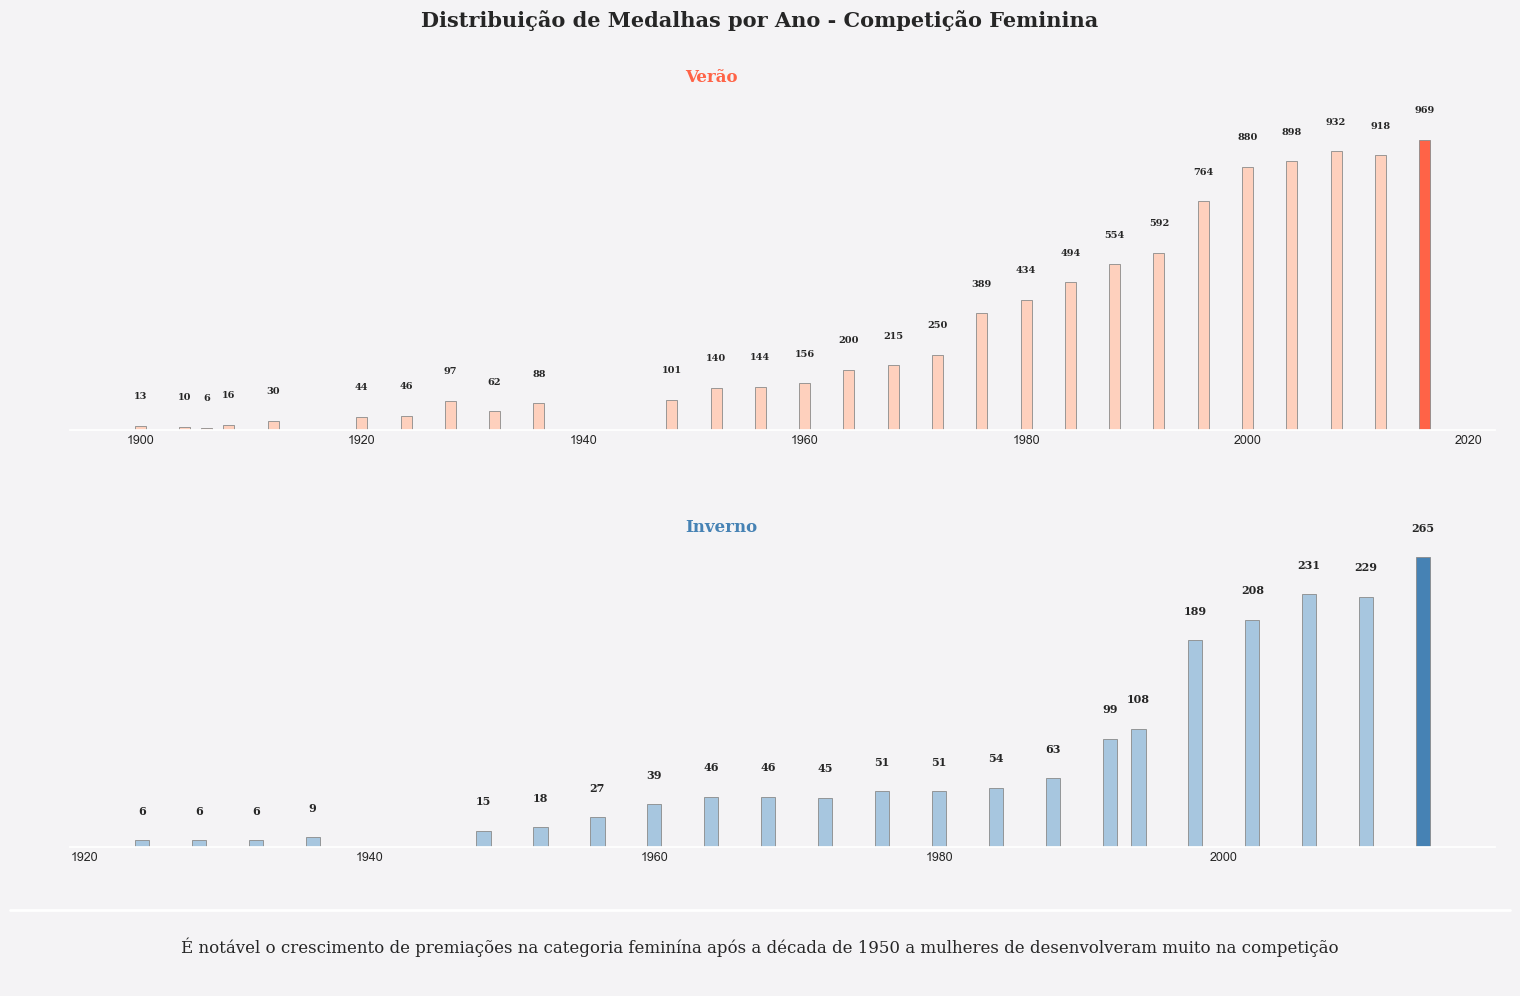

In [164]:
mulheres_verao = mesclado[(mesclado.Sex == 'F') & (mesclado.Season == "Summer")]
mulheres_verao = mulheres_verao.groupby(['Year'])['Medal'].count().reset_index()
mulheres_verao.set_index('Year', inplace=True)

mulhes_inverno = mesclado[(mesclado.Sex == 'F') & (mesclado.Season == "Winter")]
mulhes_inverno = mulhes_inverno.groupby(['Year'])['Medal'].count().reset_index()
mulhes_inverno.set_index('Year', inplace=True)

max_verao = mulheres_verao['Medal'].max()
max_inverno = mulhes_inverno['Medal'].max()

# Preparar os mapas de cores
color_map_verao = [cores_verao[0] if count != max_verao else cores_verao[1] for count in mulheres_verao['Medal']]
color_map_inverno = [cores_inverno[0] if count != max_inverno else cores_inverno[1] for count in mulhes_inverno['Medal']]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 9), facecolor=cor_fundo_padrao)

# As bordas de ambos os gráficos são removidas
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

# Definindo a cor de fundo dos gráficos
ax.set_facecolor(cor_fundo_padrao)
ax2.set_facecolor(cor_fundo_padrao)


# Plotando os graficos em seus eixos
ax.bar(x=mulheres_verao.index, height=mulheres_verao['Medal'],width=1, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_verao
       )

ax2.bar(x=mulhes_inverno.index, height=mulhes_inverno['Medal'],width=1, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map_inverno
       )

# Inserindo os rotulos de dados
for i in mulheres_verao.index:
    ax.annotate(f"{formata_valor(mulheres_verao.at[i, 'Medal'])}", 
                xy=(i, mulheres_verao.at[i, 'Medal'] + max_verao*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=7)
    
# Adicionando rótulo de dados
for i in mulhes_inverno.index:
    ax2.annotate(f"{formata_valor(mulhes_inverno.at[i, 'Medal'])}", 
                xy=(i, mulhes_inverno.at[i, 'Medal'] +  max_inverno*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8)

# Modificando os eixos
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_verao * 1.2)
ax.set_facecolor(cor_fundo_padrao)

ax2.grid()
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='both',length=0)
ax2.set_ylim(0, max_inverno * 1.2)
ax2.set_facecolor(cor_fundo_padrao)

fig.suptitle('Distribuição de Medalhas por Ano - Competição Feminina', fontsize=15, fontweight='bold', fontfamily='serif')

l1 = lines.Line2D([0, 1], [-0.02, -0.02], transform=fig.transFigure, figure=fig, color='white', lw=2)
fig.lines.extend([l1])

texto = """
    É notável o crescimento de premiações na categoria feminína após a década de 1950 a mulheres de desenvolveram muito na competição
"""

fig.text(0.1, -0.09, texto, fontsize=12, fontweight='light', fontfamily='serif', ha='left')
fig.text(0.1, -0.1, 'margin', fontsize=12, fontweight='light', fontfamily='serif', ha='left', color=cor_fundo_padrao)


plt.subplots_adjust(left=0.04, right=0.99, top=0.9, bottom=0.05)
fig.text(0.45, 0.9, 'Verão', fontsize=12, fontweight='bold', fontfamily='serif', color='#FF6347')
fig.text(0.45, 0.4, 'Inverno', fontsize=12, fontweight='bold', fontfamily='serif', color='#4682B4')

### Evolução do número de competidoras

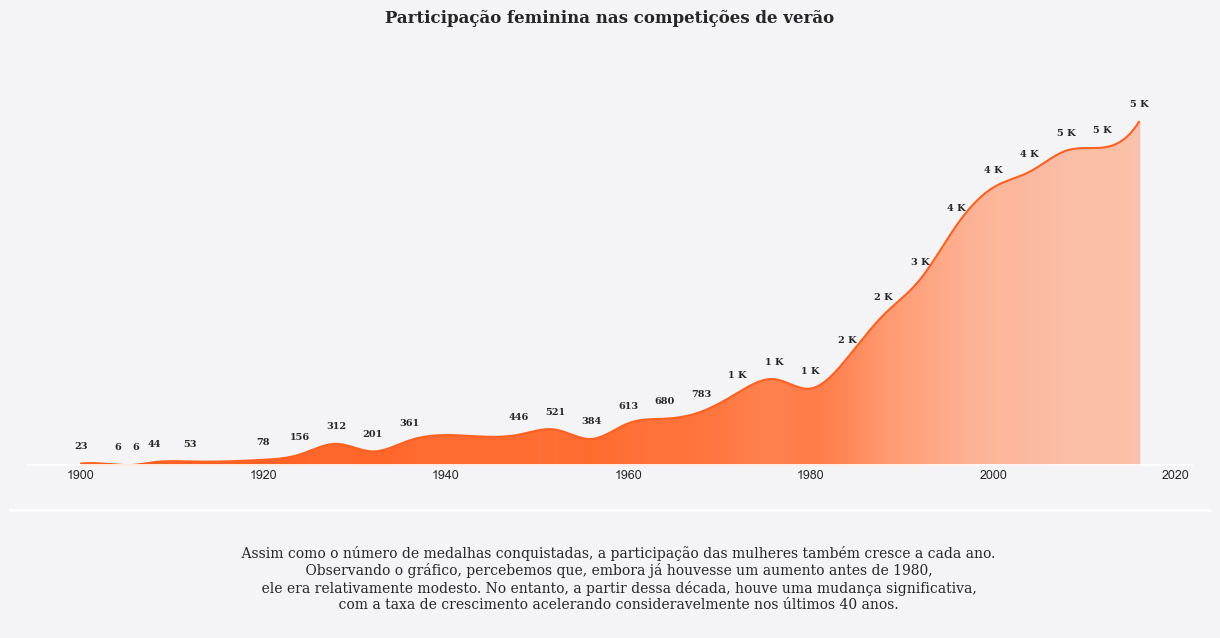

In [182]:
mulheres_unicas = mesclado[(mesclado.Sex == 'F') & (mesclado.Season == "Summer")].drop_duplicates(subset=['ID', 'Year'])
mulheres_unicas = mulheres_unicas.groupby(['Year'])['Year'].value_counts().sort_index(ascending=True).reset_index()
mulheres_unicas.set_index('Year', inplace=True)

max_ = mulheres_unicas['count'].max()

# Dados do gráfico
x = mulheres_unicas.index.values
y = mulheres_unicas['count'].values

spl = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = splev(x_smooth, spl)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), facecolor=cor_fundo_padrao)

ax.plot(x_smooth, y_smooth, marker='', linestyle='-', color='#FF6122')
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_ * 1.2)
ax.set_facecolor(cor_fundo_padrao)

for i in mulheres_unicas.index:
    ax.annotate(f"{formata_valor(mulheres_unicas.at[i, 'count'])}", 
                xy=(i, mulheres_unicas.at[i, 'count'] + max_*0.05),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=7)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Criando um degradê de cores para o preenchimento
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

cmap = LinearSegmentedColormap.from_list("golden_gradient", [ "#FF6122", "#FFA07A", "#FAC3AE"])
norm = mcolors.Normalize(vmin=y_smooth.min(), vmax=y_smooth.max())

# Preenchendo o gráfico com o degradê
for i in range(len(x_smooth) - 1):
    ax.fill_between(x_smooth[i:i + 2], y1=y_smooth[i:i + 2], y2=0, color=cmap(norm(y_smooth[i])))

l1 = lines.Line2D([0, 1], [-0.02, -0.02], transform=fig.transFigure, figure=fig, color='white', lw=2)
fig.lines.extend([l1])

texto = """
    Assim como o número de medalhas conquistadas, a participação das mulheres também cresce a cada ano.
    Observando o gráfico, percebemos que, embora já houvesse um aumento antes de 1980,
    ele era relativamente modesto. No entanto, a partir dessa década, houve uma mudança significativa,
    com a taxa de crescimento acelerando consideravelmente nos últimos 40 anos.
"""

fig.text(0.5, -0.25, texto, fontsize=10, fontweight='light', fontfamily='serif', ha='center')
fig.text(0.1, -0.17, 'margin', fontsize=12, fontweight='light', fontfamily='serif', ha='left', color=cor_fundo_padrao)

plt.subplots_adjust(left=0.04, right=0.99, top=0.9, bottom=0.05)
plt.suptitle('Participação feminina nas competições de verão', fontsize=12, fontweight='bold', fontfamily='serif')
plt.tight_layout()

<br><br>
## Medalhas de Ouro
___

Veremos nessa seção a distribuição de medalhas de ouro por certas categorias.

### Medalhas de ouro por País

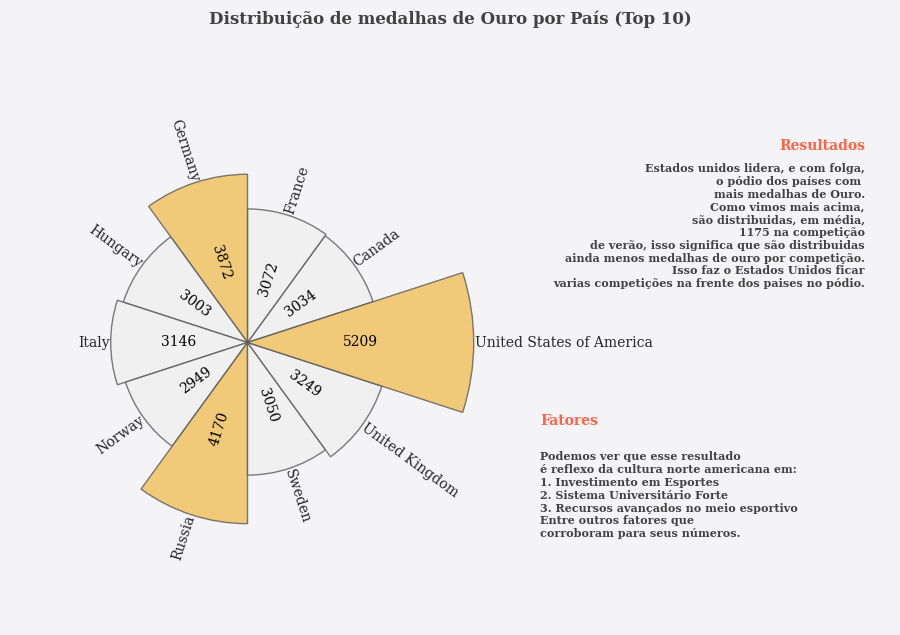

In [648]:
medalhas_ouro_regiao = mesclado.query("Medal == 'Gold'").groupby(['region'])['Medal'].value_counts().unstack()
medalhas_ouro_regiao = medalhas_ouro_regiao.sort_values(by='Gold', ascending=False).reset_index()

top_10_medalhas_ouro = medalhas_ouro_regiao[:10]

ranking_map = {region: i for i, region in enumerate(top_10_medalhas_ouro['region'])}

top_10_medalhas_ouro = top_10_medalhas_ouro.sort_values(by='region').set_index('region').reset_index()

color_map = ['#F0F0F0' for _ in range(0, 10)]   # Definindo as cores
for i, region in enumerate(top_10_medalhas_ouro['region']):
    if ranking_map[region] < 3:  # Se estiver nos três primeiros no ranking original
        color_map[i] = '#F0C05A'  # Cor de destaque

fig, ax1 = plt.subplots(1,1, figsize=(5,5), facecolor=cor_fundo_padrao)
ax = plt.subplot(111, polar=True)
ax1.set_facecolor(cor_fundo_padrao)
ax1.grid()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
for s in ['top', 'left', 'right', 'bottom']:
    ax1.spines[s].set_visible(False)

upperLimit = 3000   # Limite superior das fatias
lowerLimit = 10     # Limite inferior das fatias (onde começam em relação ao eixo cartesiano)
labelPadding = 35   # Define a distância mínima do rótulo do país

max_ = top_10_medalhas_ouro['Gold'].max()
min_ = top_10_medalhas_ouro['Gold'].min()

# Calcula a angulatura da barra
slope = (max_ - lowerLimit) / (max_ - min_)  
alturas = slope * top_10_medalhas_ouro['Gold'] + (upperLimit- lowerLimit)
indexes = list(range(1, len(top_10_medalhas_ouro.index)+1))
largura = 2*np.pi / len(top_10_medalhas_ouro.index)
angulos = [element * largura for element in indexes]

# Configurando as barras (slices) do nosso gráfico
bars = ax.bar(
    x=angulos, 
    height=alturas, 
    width=largura, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor=cinzas[-2],
    color=color_map, alpha=0.8
)

# Itera sobre as regiões para adicionar os rótulos de dados e labels dos países
for barra, angulo, altura, label in zip(bars, angulos, alturas, top_10_medalhas_ouro["region"]):

    rotacao = np.rad2deg(angulo)   # Converte radianos para graus

    alinhamento = ""
    if angulo >= np.pi/2 and angulo < 3*np.pi/2:  # Se estiver entre o segundo e terceiro quadrante, mudamos o alinhamento
        alinhamento = "right"
        rotacao = rotacao + 180
    else: 
        alinhamento = "left"

    # Adiciona o label
    ax.text(
        x=angulo, 
        y=lowerLimit + barra.get_height() + labelPadding, 
        s=label, 
        ha=alinhamento, fontsize=10, fontfamily='serif',
        va='center', 
        rotation=rotacao, 
        rotation_mode="anchor"
    )

    # Adiciona o rótulo de dados
    ax.text(
        x=angulo, 
        y=lowerLimit + barra.get_height()/2,
        s=f"{int(barra.get_height() / slope)}", 
        ha='center', fontsize=10, fontfamily='serif',
        va='center', color='black', rotation=rotacao, 
        rotation_mode="anchor"
    )

texto = f"""
Estados unidos lidera, e com folga,
o pódio dos países com 
mais medalhas de Ouro.
Como vimos mais acima,
são distribuidas, em média,
{media_medalha_comp_verao:.0f} na competição
de verão, isso significa que são distribuidas
ainda menos medalhas de ouro por competição.
Isso faz o Estados Unidos ficar
varias competições na frente dos paises no pódio.
"""

texto2 = """
Podemos ver que esse resultado
é reflexo da cultura norte americana em:
1. Investimento em Esportes
2. Sistema Universitário Forte
3. Recursos avançados no meio esportivo
Entre outros fatores que
corroboram para seus números.
"""

# Adicionando textos e ajustes finais
fig.text(1.75, 0.7, "Resultados", fontsize=10, fontweight='bold', fontfamily='serif', ha='right', color=cores_verao[-1])
fig.text(1.75, 0.4, texto, fontsize=8, fontweight='bold', fontfamily='serif', ha='right', color=cinzas[-1])
fig.text(1.1, 0.15, "Fatores", fontsize=10, fontweight='bold', fontfamily='serif', ha='left', color=cores_verao[-1])
fig.text(1.1, -0.1, texto2, fontsize=8, fontweight='bold', fontfamily='serif', ha='left', color=cinzas[-1])
fig.text(1.8, -0.17, 'margin', fontsize=12, fontweight='light', fontfamily='serif', ha='right', color=cor_fundo_padrao)

plt.axis('off')
plt.suptitle('Distribuição de medalhas de Ouro por País (Top 10)', fontsize=12, fontweight='bold', fontfamily='serif', x=0.92, color=cinzas[-1])
plt.subplots_adjust(left=0.04, right=0.99, top=0.88, bottom=-0.25)


### Medalhas de Ouro por Esporte

Vamos explorar os esportes e descobrir quem se destaca na competição.

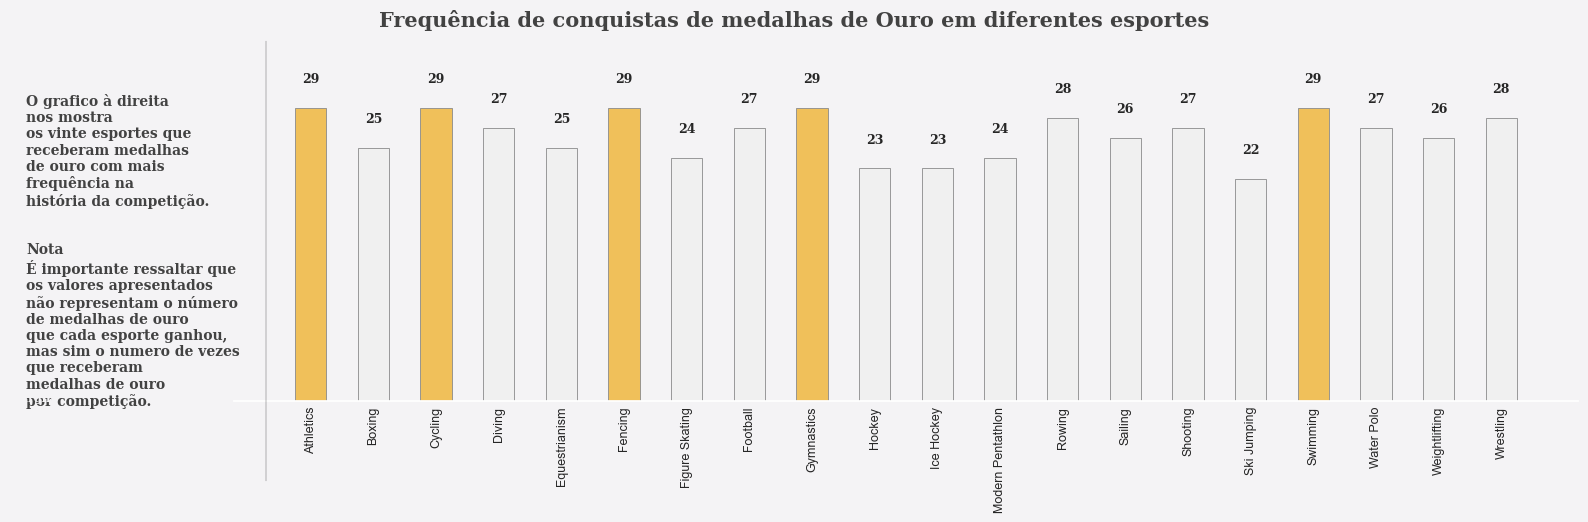

In [708]:
medalhas_ouro_regiao = mesclado.query("Medal == 'Gold'").groupby(['Year', 'Sport']).first()
top_20_esportes_ouro = medalhas_ouro_regiao.reset_index()['Sport'].value_counts().reset_index()[:20]

max_ = top_20_esportes_ouro['count'].max()

ranking_sport = {sport: i for i, sport in enumerate(top_20_esportes_ouro['Sport'])}

top_20_esportes_ouro = top_20_esportes_ouro.sort_values(by='Sport').set_index('Sport').reset_index()

color_map = ['#F0F0F0' for _ in range(0, 20)]   # Definindo as cores
for i, e in enumerate(top_20_esportes_ouro['Sport']):
    if top_20_esportes_ouro.iloc[i]['count'] == max_:
        color_map[i] = '#F0C05A'  # Cor de destaque

fig, ax = plt.subplots(1,1, figsize=(16,4), facecolor=cor_fundo_padrao)

# Plotando os graficos em seus eixos
ax.bar(x=top_20_esportes_ouro['Sport'], height=top_20_esportes_ouro['count'],width=0.5, 
       edgecolor=cinzas[0],
       linewidth=0.6, color=color_map
       )

# Modificando os eixos
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)
ax.set_ylim(0, max_ * 1.2)
ax.set_facecolor(cor_fundo_padrao)
ax.set_xticklabels(top_20_esportes_ouro['Sport'], rotation=90)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Inserindo os rotulos de dados
for i in top_20_esportes_ouro.index:
    ax.annotate(f"{formata_valor(top_20_esportes_ouro.at[i, 'count'])}", 
                xy=(i, top_20_esportes_ouro.at[i, 'count'] + max_*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=9)

texto1 = '''
O grafico à direita 
nos mostra
os vinte esportes que
receberam medalhas
de ouro com mais
frequência na 
história da competição.


Nota
É importante ressaltar que
os valores apresentados
não representam o número
de medalhas de ouro
que cada esporte ganhou,
mas sim o numero de vezes
que receberam 
medalhas de ouro
por competição.
'''

plt.suptitle('Frequência de conquistas de medalhas de Ouro em diferentes esportes',
            fontsize=15, fontweight='bold', fontfamily='serif', ha='center', color=cinzas[-1])
fig.text(0.02, -0.05, texto1, fontsize=10, fontweight='bold', fontfamily='serif', ha='left', color=cinzas[-1])
fig.text(0.01, 0, 'margin', fontsize=8, fontweight='bold', fontfamily='serif', ha='left', color=cor_fundo_padrao)

l1 = lines.Line2D([0.17, 0.17], [-0.2, 0.9], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.99, top=0.88, bottom=-0)


### Medalhas de Ouro por Idade

Agora, vamos verificar a distribuição de medalhas de ouro por Idade. Qual a idade que mais recebe as medalhas douradas?

Text(0.43, 0.48, '\nComo podemos notar, a faixa etária dos 20 anos de idade é quem recebe o maior numero de medalhas de ouro.\nAbaixo iremos abrir os extremos do grafico e analisar quais esportes estão atrelados a esses atletas.\n')

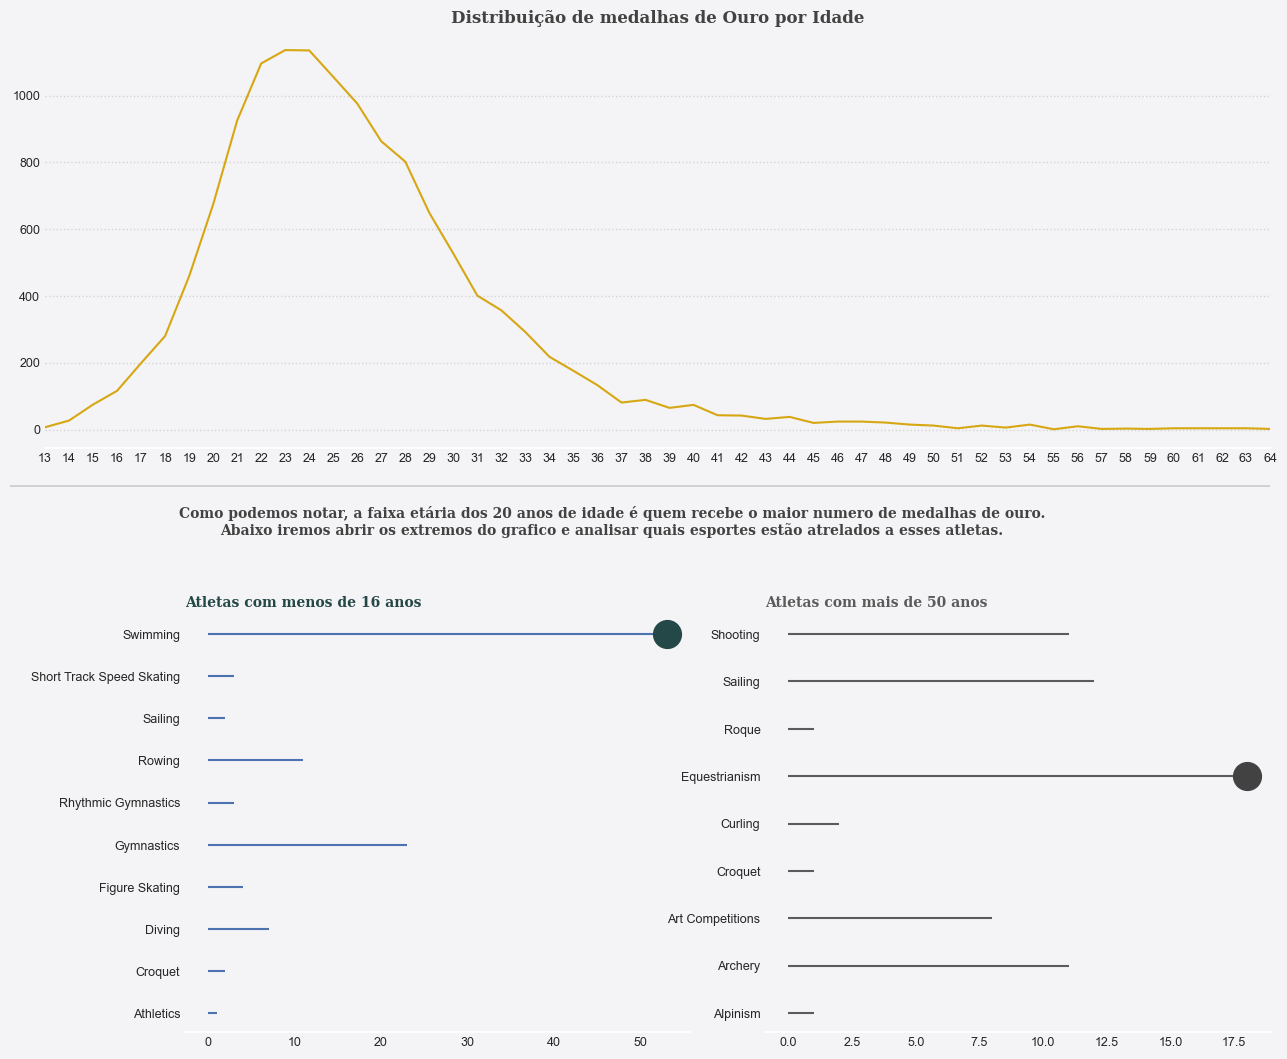

In [700]:
medalhas_ouro = mesclado.query("Medal == 'Gold'")
medalhas_ouro = medalhas_ouro[np.isfinite(medalhas_ouro['Age'])]
medalhas_ouro['Age'] = medalhas_ouro['Age'].astype(int)

fig = plt.figure(figsize=(14, 13), facecolor=cor_fundo_padrao)

# Primeiro subplot que ocupa toda a linha superior
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

# Segundo subplot na segunda linha, primeira coluna
ax2 = plt.subplot2grid((2, 2), (1, 0))

# Terceiro subplot na segunda linha, segunda coluna
ax3 = plt.subplot2grid((2, 2), (1, 1))

# Aplicando configuraçções gerais para cada subplot
for ax_ in [ax, ax2, ax3]:
    ax_.grid()
    for s in ['top', 'left', 'right']:
        ax_.spines[s].set_visible(False)
    ax_.tick_params(axis='both', which='major', labelsize=9)
    ax_.tick_params(axis='both', which='both',length=0)
    ax_.set_facecolor(cor_fundo_padrao)

# Grafico 1: Distribuição de medalhas por idade
medalhas_ouro_idade = medalhas_ouro.groupby('Age')['Age'].value_counts().reset_index()

ax.plot(medalhas_ouro_idade['Age'], medalhas_ouro_idade['count'], linestyle='-', color=dourados[-1])
full_age_range = np.arange(medalhas_ouro_idade['Age'].min(), medalhas_ouro_idade['Age'].max() + 1)
ax.set_xticks(full_age_range)
ax.set_xlim(medalhas_ouro_idade['Age'].min(), medalhas_ouro_idade['Age'].max())
ax.yaxis.grid(True, linestyle=':', which='both', color=cinzas[0], alpha=0.3)
ax.set_title('Distribuição de medalhas de Ouro por Idade',
            fontsize=12, fontweight='bold', fontfamily='serif', ha='center', color=cinzas[-1])

# Grafico 2: Distribuição de Medalhas por Esporte (< 16 anos)
medalhas_ouro_16 = medalhas_ouro.query("Age < 16").groupby('Sport')['Sport'].value_counts().reset_index()

x_min_16 = medalhas_ouro_16['count'].min()
x_max_16 = medalhas_ouro_16['count'].max()

ax2.hlines(y=medalhas_ouro_16['Sport'],xmin=0, xmax=medalhas_ouro_16['count'])
ax2.plot(medalhas_ouro_16[medalhas_ouro_16['count']==x_max_16]['count'],
        medalhas_ouro_16[medalhas_ouro_16['count']==x_max_16]['Sport'],
        'o', markersize=20, color='#244747')
ax2.set_title('Atletas com menos de 16 anos', loc='left', color='#244747', fontsize=10, fontweight='bold', fontfamily='serif')

# Grafico 3: Distribuição de Medalhas por Esporte (> 50 anos)
medalhas_ouro_50 = medalhas_ouro.query("Age > 50").groupby('Sport')['Sport'].value_counts().reset_index()

x_min_50 = medalhas_ouro_50['count'].min()
x_max_50 = medalhas_ouro_50['count'].max()

ax3.hlines(y=medalhas_ouro_50['Sport'],xmin=0, xmax=medalhas_ouro_50['count'], colors=cinzas[-2])
ax3.plot(medalhas_ouro_50[medalhas_ouro_50['count']==x_max_50]['count'],
        medalhas_ouro_50[medalhas_ouro_50['count']==x_max_50]['Sport'],
        'o', markersize=20, color= cinzas[-1])
ax3.set_title('Atletas com mais de 50 anos', loc='left', color=cinzas[-2], fontsize=10, fontweight='bold', fontfamily='serif')

plt.subplots_adjust(hspace=0.4, wspace=0.15)

l1 = lines.Line2D([0, 0.9], [0.53, 0.53], transform=fig.transFigure, figure=fig, color='black', lw=.2)
fig.lines.extend([l1])

# Ajuste manual da posição do ax pois os dados dos gráficos abaixo podem alterar sua posição 
box = ax.get_position()
ax.set_position([box.x0 - 0.1, box.y0, box.width + 0.1, box.height])

# Textos
texto1 = """
Como podemos notar, a faixa etária dos 20 anos de idade é quem recebe o maior numero de medalhas de ouro.
Abaixo iremos abrir os extremos do grafico e analisar quais esportes estão atrelados a esses atletas.
"""

fig.text(0.43,0.48, s=texto1, fontsize=10, fontweight='bold', fontfamily='serif', ha='center', color=cinzas[-1])
